In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://aprodigcodata.s3.eu-north-1.amazonaws.com/df_modelo.csv')
display(df.head())

,PB,INDICADOR,NIVEL_PIRAMIDE,RANGO_EDAD,PB1,SEXO,ESTRATO,P33,ipm_depto,INDICE,saber_punt_global_mean
0,8001,0.000000,0,7,1,2,2,0.0,0.230189,"15,81",286.622745
1,5001,0.000000,0,6,1,2,2,0.0,0.212018,"24,42",256.242312
2,5001,0.000000,0,6,1,2,2,0.0,0.212018,"24,42",256.242312
3,5001,0.076923,1,4,1,1,2,1.0,0.212018,"24,42",256.242312
4,68001,0.461538,2,4,1,1,2,2.0,0.207674,"24,13",302.117450


In [ ]:
# Convert 'INDICE' to float
df['INDICE'] = df['INDICE'].str.replace(',', '.').astype(float)

X = df.drop(columns=['NIVEL_PIRAMIDE'])
y = df['NIVEL_PIRAMIDE']

# drop IDs if not predictive
X = X.drop(columns=['PB'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

display(X_train.head())

,INDICADOR,RANGO_EDAD,PB1,SEXO,ESTRATO,P33,ipm_depto,INDICE,saber_punt_global_mean
2712,0.692308,3,1,1,4,1.0,0.158780,25.31,288.624269
2581,0.000000,6,1,1,3,0.0,0.214016,17.26,253.241713
905,0.000000,4,2,2,1,0.0,0.264616,0.56,244.000000
3290,0.076923,1,1,1,2,2.0,0.212018,23.64,265.437500
460,0.153846,5,1,2,3,3.0,0.265944,15.48,252.610512


In [3]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = ('scaler', StandardScaler())

models_and_grids = {
    "LogisticRegression": {
        "estimator": Pipeline([
            scaler,
            ('clf', LogisticRegression(max_iter=5000, solver='saga', class_weight='balanced'))
        ]),
        "param_grid": {
            'clf__C': [0.01, 0.1, 1, 3, 10],
            'clf__penalty': ['l1', 'l2', 'elasticnet'],
            'clf__l1_ratio': [0.0, 0.5, 1.0]  # used only when penalty='elasticnet'
        }
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "param_grid": {
            'n_estimators': [200, 500, 800],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'max_features': ['sqrt', 'log2', 0.5],
        }
    },
    "GradientBoosting": {
        "estimator": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            'n_estimators': [200, 400, 800],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [2, 3, 4],
            'subsample': [1.0, 0.7],
        }
    },
    "SVC": {
        "estimator": Pipeline([
            scaler,
            ('clf', SVC(kernel='rbf', probability=True))
        ]),
        "param_grid": {
            'clf__C': [0.1, 1, 3, 10],
            'clf__gamma': ['scale', 0.01, 0.1, 1.0],
        }
    },
    "KNN": {
        "estimator": Pipeline([
            scaler,
            ('clf', KNeighborsClassifier())
        ]),
        "param_grid": {
            'clf__n_neighbors': [3, 5, 7, 11, 21],
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2],  # Manhattan vs Euclidean
        }
    }
}



In [ ]:

# GridSearchCV para cada modelo
results_rows = []
best_models = {}

for name, spec in models_and_grids.items():
    print(f"\n=== Tuning {name} ===")
    grid = GridSearchCV(
        estimator=spec['estimator'],
        param_grid=spec['param_grid'],
        scoring='accuracy',
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    y_pred = grid.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')

    results_rows.append({
        'Model': name,
        'CV mean accuracy': grid.best_score_,
        'Test accuracy': acc,
        'Test F1 (macro)': f1m,
        'Best params': grid.best_params_
    })

results_df = pd.DataFrame(results_rows).sort_values('Test accuracy', ascending=False).reset_index(drop=True)
print("\n=== Model comparison ===")
display(results_df)


=== Tuning LogisticRegression ===


/Users/nacho/Documents/MaestriaStudying/ProyectoAplicado/Entrega3/ApropiacionDigital/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/nacho/Documents/MaestriaStudying/ProyectoAplicado/Entrega3/ApropiacionDigital/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/nacho/Documents/MaestriaStudying/ProyectoAplicado/Entrega3/ApropiacionDigital/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/nacho/Documents/MaestriaStudying/ProyectoAplicado/Entrega3/ApropiacionDigital/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter i


=== Tuning RandomForest ===

=== Tuning GradientBoosting ===

=== Tuning SVC ===

=== Tuning KNN ===

=== Model comparison ===


,Model,CV mean accuracy,Test accuracy,Test F1 (macro),Best params
0,GradientBoosting,0.839196,0.832138,0.676314,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est..."
1,SVC,0.833450,0.823529,0.641398,"{'clf__C': 10, 'clf__gamma': 0.01}"
2,RandomForest,0.831293,0.793400,0.673468,"{'max_depth': 10, 'max_features': 'sqrt', 'min..."
3,LogisticRegression,0.809763,0.790531,0.692504,"{'clf__C': 0.1, 'clf__l1_ratio': 0.5, 'clf__pe..."
4,KNN,0.758077,0.715925,0.558738,"{'clf__n_neighbors': 11, 'clf__p': 1, 'clf__we..."


In [ ]:
#Evaluar dos de los mejores modelos, para GraidentBoosting obtuvimos el mejor Accuracy y para LogisticRegression el mejor F1-macro
print("=== GradientBoosting Classification Report ===")
print(classification_report(y_test, best_models['GradientBoosting'].predict(X_test)))
print("=== LogisticRegression Classification Report ===")
print(classification_report(y_test, best_models['LogisticRegression'].predict(X_test)))

=== GradientBoosting Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       212
           1       0.82      0.86      0.84       281
           2       0.67      0.71      0.69       177
           3       0.50      0.11      0.18        27

    accuracy                           0.83       697
   macro avg       0.75      0.67      0.68       697
weighted avg       0.83      0.83      0.82       697

=== LogisticRegression Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       212
           1       0.82      0.86      0.84       281
           2       0.66      0.46      0.54       177
           3       0.28      0.70      0.40        27

    accuracy                           0.79       697
   macro avg       0.69      0.75      0.69       697
weighted avg       0.81      0.79      0.79       697



In [ ]:
# Ajustar GradientBoosting con pesos de muestra balanceados
print("=== GradientBoosting with balanced sample weights ===")
sample_w = compute_sample_weight(class_weight='balanced', y=y_train)
best_gb = best_models['GradientBoosting']   
best_gb.fit(X_train, y_train, sample_weight=sample_w)
print(classification_report(y_test, best_gb.predict(X_test)))

=== GradientBoosting with balanced sample weights ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       212
           1       0.88      0.77      0.82       281
           2       0.60      0.56      0.58       177
           3       0.25      0.74      0.38        27

    accuracy                           0.78       697
   macro avg       0.68      0.76      0.69       697
weighted avg       0.82      0.78      0.79       697




Class 0
INDICADOR                -13.222864
RANGO_EDAD                 0.398023
ESTRATO                   -0.060877
INDICE                    -0.021101
PB1                        0.000000
SEXO                       0.000000
P33                        0.000000
ipm_depto                  0.000000
saber_punt_global_mean     0.000000
Name: 0, dtype: float64

Class 1
P33                       0.170343
RANGO_EDAD               -0.095494
ipm_depto                 0.055763
ESTRATO                  -0.015228
INDICADOR                 0.000000
PB1                       0.000000
SEXO                      0.000000
INDICE                    0.000000
saber_punt_global_mean    0.000000
Name: 1, dtype: float64

Class 2
INDICADOR                 2.012068
RANGO_EDAD               -0.123911
ESTRATO                   0.055259
SEXO                      0.021670
PB1                       0.000000
P33                       0.000000
ipm_depto                 0.000000
INDICE                    0.000000
saber_

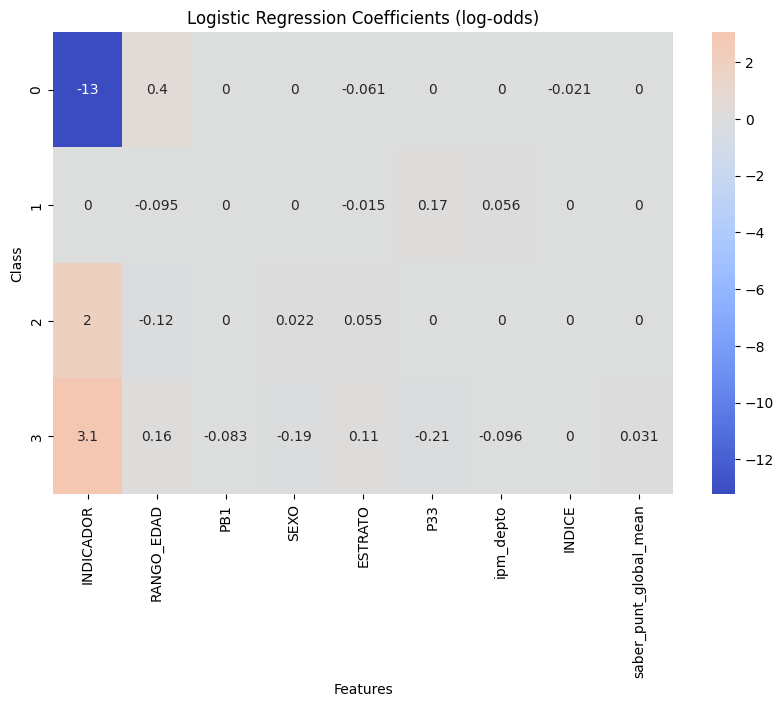

In [17]:
for i, class_label in enumerate(best_models['LogisticRegression'].named_steps['clf'].classes_):
    print(f"\nClass {class_label}")
    sorted_coefs = coefs.iloc[i].sort_values(key=abs, ascending=False)
    print(sorted_coefs.head(10)) 

plt.figure(figsize=(10,6))
sns.heatmap(coefs, annot=True, cmap="coolwarm", center=0)
plt.xlabel("Features")
plt.ylabel("Class")
plt.title("Logistic Regression Coefficients (log-odds)")
plt.show()

In [ ]:

# Mejor modelo piramide
from joblib import dump
top_model = best_models['LogisticRegression']
dump(top_model, 'model_nivel_piramide.joblib')
print("Saved best model to model_nivel_piramide.joblib")

Saved best model to model_nivel_piramide.joblib



Class 0
INDICADOR                -13.222864
RANGO_EDAD                 0.398023
ESTRATO                   -0.060877
INDICE                    -0.021101
PB1                        0.000000
SEXO                       0.000000
P33                        0.000000
ipm_depto                  0.000000
saber_punt_global_mean     0.000000
Name: 0, dtype: float64

Class 1
P33                       0.170343
RANGO_EDAD               -0.095494
ipm_depto                 0.055763
ESTRATO                  -0.015228
INDICADOR                 0.000000
PB1                       0.000000
SEXO                      0.000000
INDICE                    0.000000
saber_punt_global_mean    0.000000
Name: 1, dtype: float64

Class 2
INDICADOR                 2.012068
RANGO_EDAD               -0.123911
ESTRATO                   0.055259
SEXO                      0.021670
PB1                       0.000000
P33                       0.000000
ipm_depto                 0.000000
INDICE                    0.000000
saber_